In [1]:
# Imports
from qiime2 import Metadata
import pandas as pd
from qiime2 import Artifact, sdk
import qiime2.plugins.metadata.actions as metadata_actions
import matplotlib.pyplot as plt
from skbio.stats import distance
from skbio.stats import ordination
import qiime2.plugins.feature_table.methods as ftm
from ete3 import Tree, TreeStyle, TreeNode
from skbio.tree import TreeNode
import matplotlib 
import os
import all_artifacts as a
import qiime2
import tempfile
from io import StringIO
import seaborn as sns
from Bio import SeqIO
from Bio import Phylo
metadata = pd.read_csv('./ds_metadata.tsv', sep='\t')
metadata.drop(0, axis='index', inplace=True)
%matplotlib inline

id_key: dict = {
    "BhM": "Bihor mountains", "BrH": "Barrow mountain high",
    "BrL": "Barrow mountain low", "CaS": "Catriona snow",
    "CeY": "Central Yakutia", "GrI": "Greenland ice", 
    "EaI": "East Iceland glaciers", "CrC": "Cryoconite",
    "HaS": "Hailstone", "NzS": "New Zealand soil", 
    "SvG": "Sverdrup glacier", "StR": "Storglaciaren",
    "ViS": "Villum station"
}

matplotlib.use('module://ipykernel.pylab.backend_inline')
pm = sdk.PluginManager()
def see(artifact):
    from_format = artifact.format
    if issubclass(from_format, sdk.plugin_manager.SingleFileDirectoryFormatBase):
        from_format = artifact.format.file.format
    return set(pm.transformers[from_format].keys())


def v2frame(viz_fp: str) -> list:
    '''viz_fp is a path to the qiime2 visualization object'''
    viz = qiime2.Visualization.load(viz_fp)
    with tempfile.TemporaryDirectory() as tmpdir:
        viz.export_data(tmpdir)
        fp = os.path.join(tmpdir, 'quality-plot.html')
        ov = os.path.join(tmpdir, 'overview.html')
        dfs = pandas.read_html(fp, index_col=0)
        df2s = pandas.read_html(ov, index_col=0)
    return dfs + df2s

def splitter(size: int, desired_size: int, num_splits: int) -> int:
    return round(size/(desired_size/num_splits))

###### Imports

In [6]:
splitter(186, 100, 10)

19

# Importing data from fastq
Qiime2 uses a compressed type of file format called an 'Artifact' for its analyses. Artifacts have different semantic types e.g. `FeatureData[Sequence]`, `Phylogeny[Unrooted]` depending on the type of data they contain. To begin the analysis, I need to import my fastq files into `FeatureData[SequencesWithQuality]` or `FeatureData[PairedEndSequencesWithQuality]`. 

Although all of these reads were prepared with Illumina devices, sequencing quality can vary between sequencing centres, meaning that each sample will likely need specific parameters for cleaning. Furthermore, two of the samples were sequenced with paired-end format. This means that I'll need to import each sample into different artifacts, merging them together once they have been cleaned. To reduce bias in sampling between sites, I have specifically looked for larger fastq files, then split them 

Quality $(Q)$ is commonly measured in Phred scores, denoted as  $Q=-10 \log_{10}P$, where $P$ is the probability of an incorrect base call. Therefore, higher values for Phred indicate a lower probability of an erroneous base. Every base position is given a Phred score, and it is common to see the score decrease the longer the read 

```bash
# Relevant commands
qiime tools import \
  --type 'SampleData[PairedEndSequencesWithQuality]' \
  --input-path devon.tsv \
  --output-path devonFQ.qza \
  --input-format PairedEndFastqManifestPhred64V2

qiime tools import \
  --type 'SampleData[SequencesWithQuality]' \
  --input-path neem.tsv \
  --output-path neem.qza \
  --input-format SingleEndFastqManifestPhred33V2
```

# Initial exploration
To get an idea of each sample's read quality, I used external tools: `FastQC` paired with `MultiQC`. I was mainly looking for the 

```bash
for sample in {Barrow_Alaska,Devon_ice_cap,Mutzagh_Ata,Greenland_ice_sheet,Neem}
    do 
        fastqc ${sample}/*
        multiqc $sample -f
    done
```

### Per base sequence quality

In [3]:
bHSQ = pd.read_csv('data/TSV_data/barrow_high/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
bLSQ = pd.read_csv('data/TSV_data/barrow_low/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
crSQ = pd.read_csv('data/TSV_data/cryoconite/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
diSQ = pd.read_csv('data/TSV_data/devon_ice/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
fsSQ = pd.read_csv('data/TSV_data/fresh_snow/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')
maSQ = pd.read_csv('data/TSV_data/mutzagh_ata/fastqc_per_base_sequence_quality_plot.tsv', sep='\t')

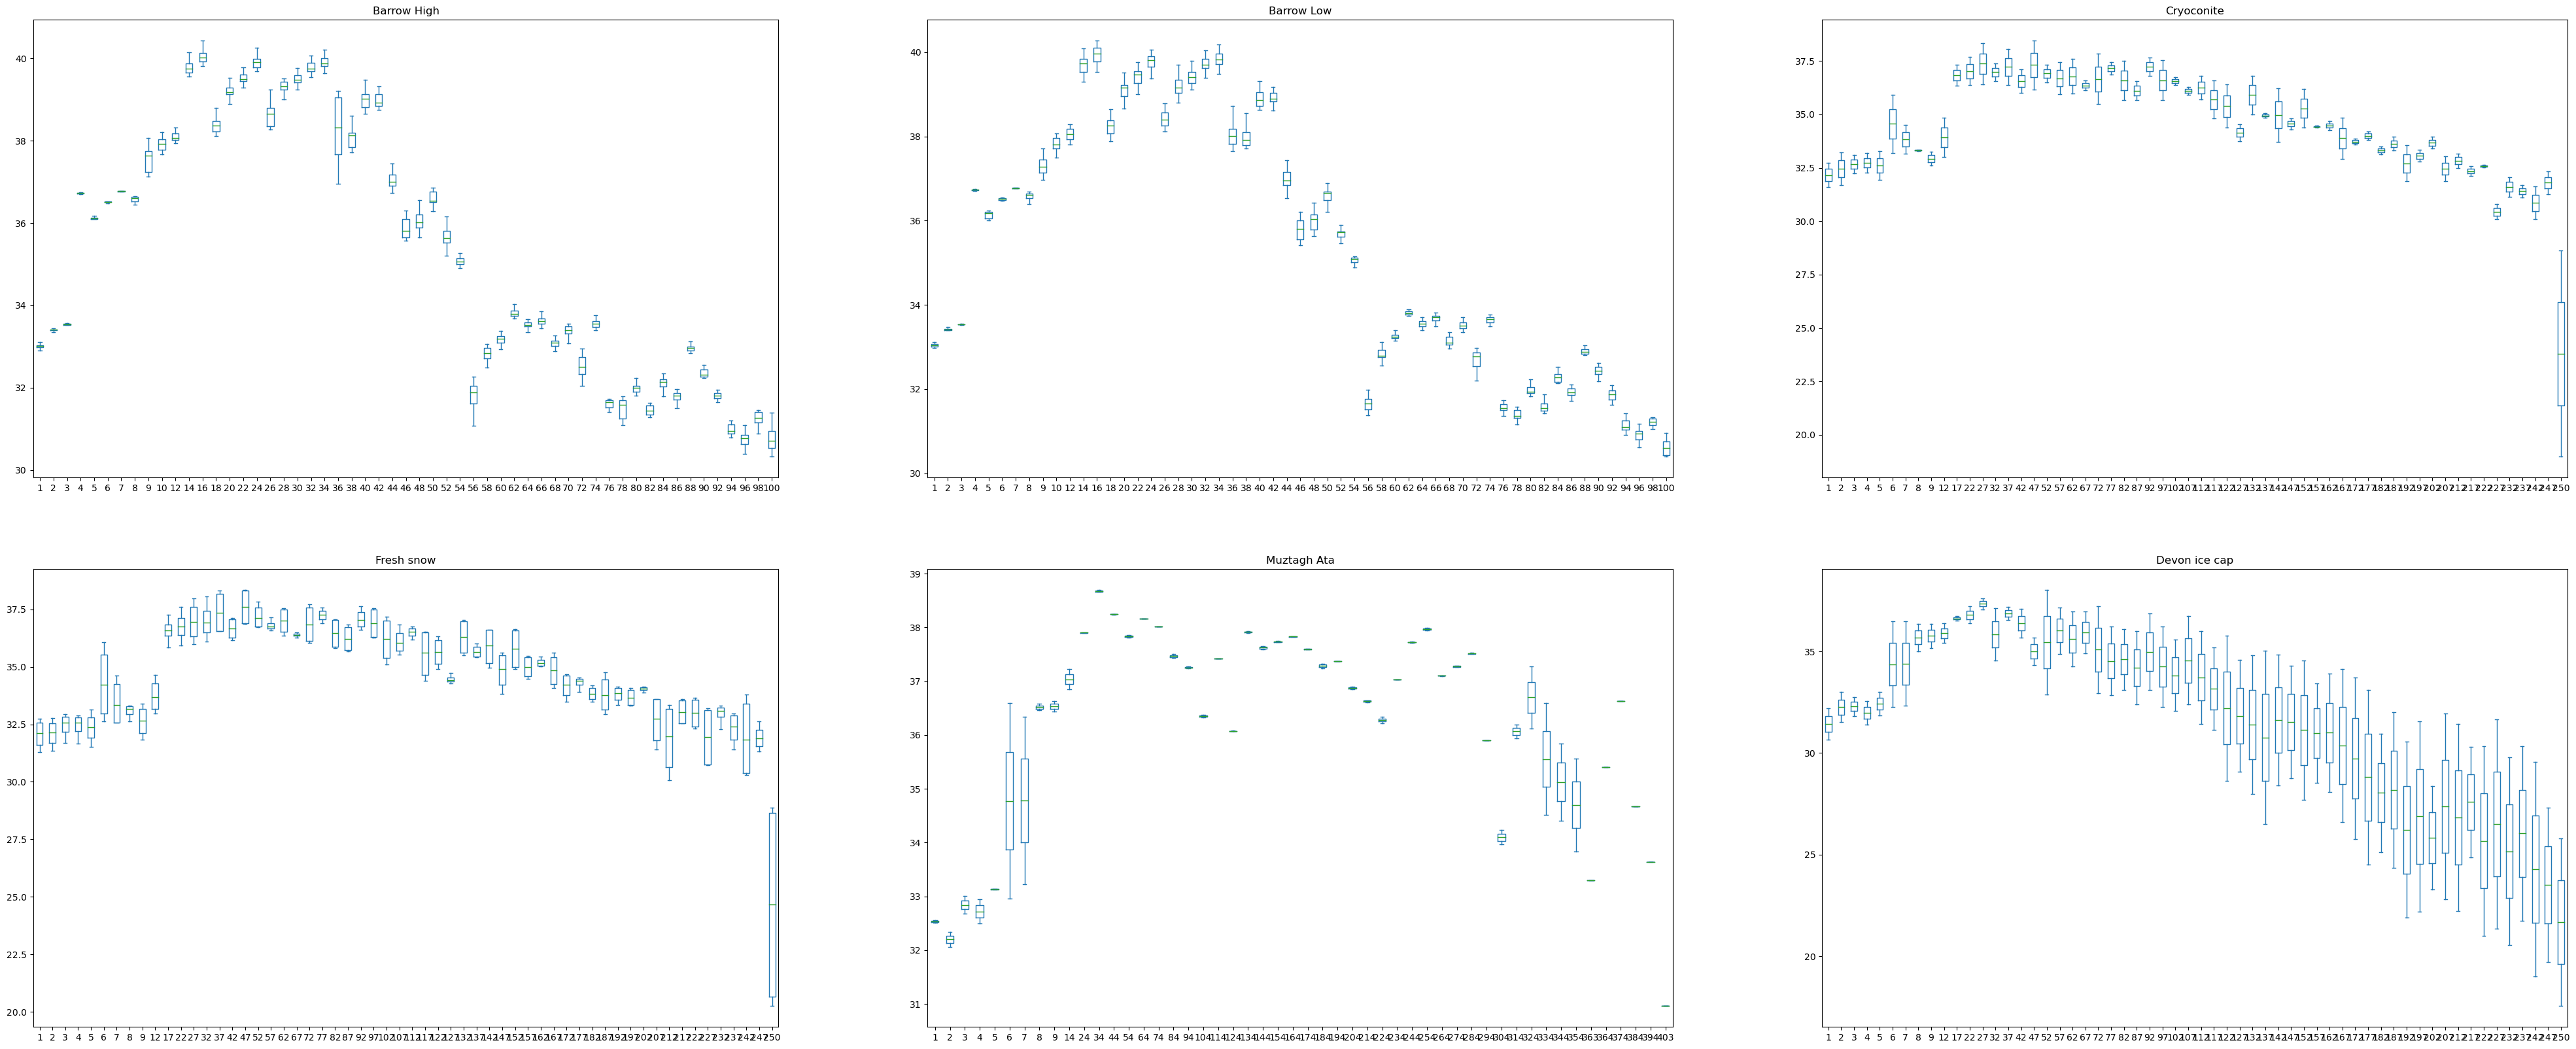

In [43]:
plots: dict = {0: (bHSQ, 'Barrow High'), 1: (bLSQ, 'Barrow Low'), 
                2: (crSQ, 'Cryoconite'), 3: (fsSQ, 'Fresh snow'), 
                4: (maSQ, 'Muztagh Ata'), 5: (diSQ, 'Devon ice cap')}
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(50, 20)
count: int = 0
for i in range(2):
    for j in range(3):
        qual = plots[count][0].set_index('Position (bp)')
        means = qual.iloc[:, 0:].dropna(axis='index').mean(axis=1)
        qual.T.plot(kind='box', ax=ax[i, j], grid=False, showfliers=False)
        ax[i,j].set(title=plots[count][1])
        count += 1

# Data cleaning
- Ordinarily, we clean fastq data by trimming the reads to a length with relatively high quality scores (e.g. the average quality at base 200+ is less than 30, so we trim to keep only the first 200 bases from the 5' end). Unfortunately, several of the samples in each site exhibit varying mean quality scores at the same base position. In addition to using a read trimmer, `dada2`, I will process the reads with a quality filter to retain high-confidence hits. An adapter filter will also be used because of the adapter content in some samples.  
- The read lengths I've trimmed to are listed in the `samplelist.tsv` file, along with the sample names

In [10]:
# View final results
crySeqs =  Artifact.load('results/1-Cleaning/Greenland_cryoconite-denoisedSeqs.qza')

# Sequence clustering

# Taxonomic analyses
For sample taxonomic classification, I will be trying out all three of the methods available in qiime2: 

#### Database preparation
Two databases were obtained:

- All annotated 16S rRNA from the NCBI ftp [website](https://ftp-ncbi-nlm-nih-gov.ejournal.mahidol.ac.th/blast/db/v5/)
- Annotated 16S rRNA used by the tool [MicFunPred](https://github.com/microDM/MicFunPred)
- A 16S rRNA database from [EzBioCloud](https://www.ezbiocloud.net/dashboard)

The MicFunPred and NCBI databases were obtained in the standard BLAST format, and need to be converted into compatible data types for import into the qiime2 workflow. Specficially, I needed to convert them into FASTA format with an associated taxonomy mapping file (in HeaderlessTSVTaxonomyFormat)
- Steps
    - 1 Extract all entries from the database in FASTA format
    - 2 Extract the header and convert it into the HeaderLessTSVTaxonomyFormat, which is a tab-delimited file of FASTA identifiers followed by their taxonomic assignments
    - 3 Remove the taxonomic assignments from the original FASTA file
    - 4 Concatenate the respective files types together, then import them files as qiime2 Artifacts
    - 5 Repeat for the other database (if both databases used the identifier conventions I could have combined them and processed them together but unfortunately this was not the case )

```bash
# 1
blastdbcmd -db NCBI_16S/16S_ribosomal_RNA -entry all > NCBI_16S.fasta
blastdbcmd -db micfun/micfun16S -entry all > micfun.fasta

# 2 
grep '>' NCBI_16S.fasta | tr -d '>' | sed 's/ /\t/' | sed 's/ /_/g' > NCBI_16SID.txt
grep '>' micfun.fasta | tr -d '>' | sed 's/_/\t/' | sort | uniq > micfunID.txt # Unfortunately several of the headers repeat 

# 3 
cat micfun.fasta | sed 's/_.*//' > micfunID.fasta
cat NCBI_16S.fasta | sed 's/ .*//' > ncbi16sID.fasta

# 4 
cat micfunID.txt NCBI_16SID.txt EzBioCloud/ezbiocloud_id_taxonomy.txt > all_mappings.txt
cat EzBioCloud/ezbiocloud_qiime_full.fasta ncbi16sID.fasta micfun.fasta > all.fasta
qiime tools import     --type FeatureData[Taxonomy]     --input-format HeaderlessTSVTaxonomyFormat     --input-path all.fasta     --output-path all_fasta.qza
qiime tools import     --type FeatureData[Taxonomy]     --input-format HeaderlessTSVTaxonomyFormat     --input-path all_uniqIDs.txt     --output-path Ids.qza
```

- Altogether, the database contains 130,122 sequences (though there might be some repetition that was overlooked)

In [ ]:
# Script for removing redundant ids
from Bio import SeqIO
import csv

exists: set = set()
mapped = open('all_uniq.fasta', 'w+')
for seq in SeqIO.parse('all.fasta', 'fasta'):
    if seq.id in exists:
        continue
    exists.add(seq.id)
    mapped.write(f'>{seq.id}\n')
    mapped.write(f'{seq.seq}\n')
mapped.close

uniq = open('all_uniqIDs.txt', 'w+')
exists2: set = set()
with open('all_mappings.txt', 'r') as i:
    for id in csv.reader(i, delimiter='\t'):
        if id[0] in exists2:
            continue
        exists2.add(id[0])
        uniq.write(f'{id[0]}\t{id[1]}\n')
uniq.close


#### Merging with other data
The qiime2 website provides links for data resources, including 16s rRNA reference sequences. These are from the SILVA and greengenes databases

In [8]:
# Import database artifacts
IDs = Artifact.load('data/artifacts/Ids.qza') 
RefSeqs = Artifact.load('data/artifacts/all_fasta.qza')
silvaSeqs = Artifact.load('data/downloads/silva-138-99-seqs.qza')
silvaIDs = Artifact.load('data/downloads/silva-138-99-tax.qza')
greenSeqs = Artifact.load('data/downloads/2022.10.backbone.full-length.fna.qza')
greenIDs = Artifact.load('data/downloads/2022.10.backbone.tax.qza')
AllIDs = ftm.merge_taxa([IDs, silvaIDs, greenIDs])
AllSeqs = ftm.merge_seqs([RefSeqs, silvaSeqs, greenSeqs])
AllIDs.merged_data.save('data/artifacts/AllIDs.qza')
AllSeqs.merged_data.save('data/artifacts/AllSeqs.qza')

KeyboardInterrupt: 

### Taxonomic classification

To maximize the number of identified OTUs, I'll be using all three qiime2 options for taxonomic classification. Two of these (BLAST and Vsearch) are traditional homology-based database searches, with BLAST using local alignment and Vsearch global. 

In [13]:
a.CeY_blast['Taxon']

Feature ID
0013fa13655157917833aae0ce64029e    d__Bacteria; p__Actinobacteriota; c__MB-A2-108...
00fda5f43cea87e1598d5c9e35b257c9                                          d__Bacteria
038a402ec0bc6ebe8680fbe77dda7ea6                                          d__Bacteria
048f7484313c455a7061df401d9a0087         d__Bacteria; p__Bacteroidota; c__Bacteroidia
04f942d3e7753e8d6712c4dc14479323    d__Bacteria; p__Proteobacteria; c__Gammaproteo...
                                                          ...                        
f8bff599ab1bb83a444866631e6b98e2    d__Bacteria; p__Proteobacteria; c__Gammaproteo...
fb1a424e0f79dd92889c6d0815cec9f4    d__Bacteria; p__Gemmatimonadota; c__Gemmatimon...
fba38e6ce37c864587b9aedcc76fd20b                                          d__Bacteria
fee243adab00187474d9f499e59e2952                                          d__Bacteria
ffa0faf9ba26c9e0aae31546805820fb    d__Bacteria; p__Proteobacteria; c__Alphaproteo...
Name: Taxon, Length: 211, dtype: object

# Phylogenetic reconstruction



### Mapping taxa to OTUs 

In [66]:
# Replace node names with ids, but need a way to clean the taxa names

# Resolve terminal nodes that have the same sister taxa
def is_terminal_node(node):
    if all([ check.is_leaf() for check in node.children ]):
        return True 
    return False
        
def unique_node(node):
    uniques = { n.name for n in node.get_sisters() }
    if len(uniques) == 1 and node.name in uniques:
        for sister in node.get_sisters():
            sister.delete()


key = a.CeY_blast['Taxon']
tree = Tree(a.CeY_Phy, format=1)
tree.ladderize()
for node in tree.traverse():
    if node.is_leaf():
        node.name = key[node.name]
for node in tree.traverse():
    if is_terminal_node(node):
        unique_node(next(node.iter_leaves()))
tree.standardize()

### Drawing trees

In [4]:
tree = Tree(a.CeYPhy, format=1)
style = TreeStyle()
style.mode = 'c'
style.show_leaf_name = False
tree.show(tree_style=style)

### Comparing trees

In [7]:
# Don't do this until you have assigned collapsed leaves into taxa. OTUs are too fickle

# for id, site in id_key.items():
#     t1 = getattr(a, f"{id}_Phy")
# BhMTree = Tree(a.BhMPhy, format=1)
# BrLTree = Tree(a.BrLPhy, format=1)
# BhMTree.robinson_foulds(BrLTree)

# Create distance matrix of pairwise tree comparisons
site_dict = {}
sites = list(id_key.values())
for i1, k1 in id_key.items():
    site_dict[k1] = []
    t1 = TreeNode.read(StringIO((getattr(a, f"{i1}_Phy"))))
    for i2, k2 in id_key.items():
        t2 = TreeNode.read(StringIO((getattr(a, f"{i2}_Phy"))))
        try:
            site_dict[k1].append(t1.compare_tip_distances(t2))
        except ValueError:
            site_dict[k1].append(-1)
dm = pd.DataFrame(site_dict, index=sites)

In [8]:
dm

,Bihor mountains,Barrow mountain high,Barrow mountain low,Catriona snow,Central Yakutia,Greenland ice,East Iceland glaciers,Cryoconite,Hailstone,New Zealand soil,Sverdrup glacier,Storglaciaren,Villum station
Bihor mountains,0.0,-1.000000e+00,-1.000000,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Barrow mountain high,-1.0,2.220446e-16,0.104998,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Barrow mountain low,-1.0,1.049984e-01,0.000000,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Catriona snow,-1.0,-1.000000e+00,-1.000000,5.551115e-17,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Central Yakutia,-1.0,-1.000000e+00,-1.000000,-1.000000e+00,0.0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Greenland ice,-1.0,-1.000000e+00,-1.000000,-1.000000e+00,-1.0,0.0,-1.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
East Iceland glaciers,-1.0,-1.000000e+00,-1.000000,-1.000000e+00,-1.0,-1.0,0.0,-1.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Cryoconite,-1.0,-1.000000e+00,-1.000000,-1.000000e+00,-1.0,-1.0,-1.0,0.0,-1.0,-1.000000e+00,-1.0,-1.0,-1.0
Hailstone,-1.0,-1.000000e+00,-1.000000,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,0.0,-1.000000e+00,-1.0,-1.0,-1.0
New Zealand soil,-1.0,-1.000000e+00,-1.000000,-1.000000e+00,-1.0,-1.0,-1.0,-1.0,-1.0,2.775558e-16,-1.0,-1.0,-1.0


# Diversity analyses
Unweighted "qualitative" metrics do not consider OTU abundance, telling you only about the presence and abundance of OTUs. They are more sensitive to rare OTUs

Weighted "quantitative" metrics consider relative OTU abundance, and are more sensitive to abundant taxa

Non-phylogenetic metrics assume everything is equally related to each other, so the presence of closely related species would contribute to higher diversity 

Phylogenetic metrics take into account similarity based on evolutionary relation, resulting in better scaling for genetic distance 

In [10]:
# Graphing functions
def plot_pcoa_2d(pcoa_data: pd.DataFrame, title: str,
                highlight: str):
    fig, ax = plt.subplots()
    classes = pcoa_data[highlight].unique()
    for c in classes:
        one_class = pcoa_data[pcoa_data[highlight] == c]
        ax.scatter(one_class.iloc[:, 0], one_class.iloc[:, 1], s=50)
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(classes)
    ax.set_title(title)
    plt.show()

## Alpha diversity

### Evenness comparisons

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbbcdb434c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbbcdb43a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbbcdb43220>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbbcdb43f40>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbbcdb52220>,
 'means': []}

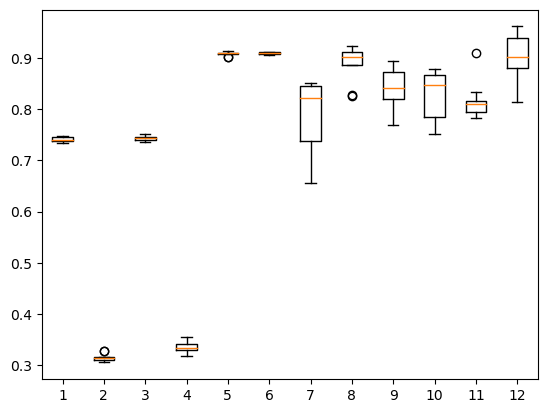

In [3]:
ignore = {'New Zealand soil'}
fig, ax = plt.subplots()
sites = []
for site in pielou_e['Location'].unique():
    if site in ignore:
        continue
    get = pielou_e[ pielou_e['Location'] == site ]['pielou_evenness']
    sites.append(get)
ax.boxplot(sites)

## Beta diversity

### PCOA on merged

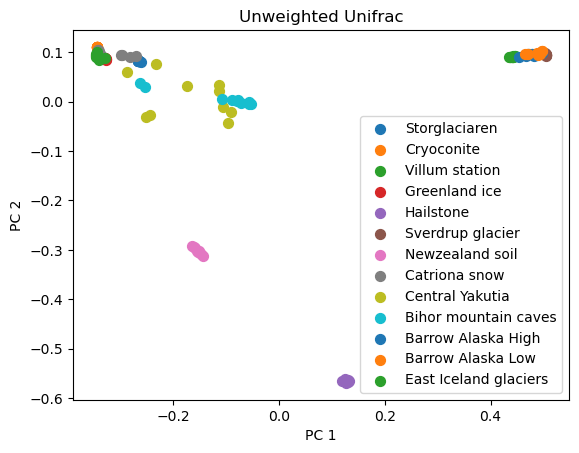

In [16]:
# Load all pcoa artifacts into dataframes and merge with metadata
from all_artifacts import *
plot_pcoa_2d(pcoaNU, 'Unweighted Unifrac', 'Location')

# References


# Data
- Barrow Alaska https://www.ebi.ac.uk/ena/browser/view/PRJEB9043, single-end, illumina hiseq 2000
single-end, 454 GS FLX
- Catriona snow  https://www.ebi.ac.uk/ena/browser/view/PRJEB9658 paired-end, illumina miseq
- Bihor Mountain ice caves https://www.ncbi.nlm.nih.gov/bioproject/305850
- Central Yakutia https://www.ncbi.nlm.nih.gov/bioproject/PRJNA734507 paired-end, illumina miseq
- South East Iceland glaciers https://www.ncbi.nlm.nih.gov/bioproject/PRJNA678168 paired
- Rhizosphere sample (comparison group) https://www.ncbi.nlm.nih.gov/bioproject/873723 single
- Sverdrup glacier https://www.ncbi.nlm.nih.gov/sra/SRX18256802[accn], paired end
- Greenland ice sheet https://www.ncbi.nlm.nih.gov/sra/SRX6813832[accn], paired end
- Storglaciaren https://www.ncbi.nlm.nih.gov/sra/ERX4489723[accn], paired end
- Cryoconite https://www.ncbi.nlm.nih.gov/sra/DRX182771[accn], paird end
- Villum station https://www.ncbi.nlm.nih.gov/sra/SRX6422141[accn], paired
- Giant hailstone metagenome https://www.ncbi.nlm.nih.gov/sra/SRX17718721[accn] single, 
- New Zealand soil https://www.ncbi.nlm.nih.gov/sra/SRX828665[accn], paired end